# Restaurants Dataset

* [Link to Dataset](https://groups.csail.mit.edu/sls/downloads/restaurant/)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer

## Preprocess Annotated Dataset and Convert To CSV

In [3]:
def preprocess_file(file):
    with open(file, 'r', encoding='utf-8') as f:
        rows = []
        sentence = 0
        for line in f.readlines():
            if line == '\n':
                sentence += 1
            else:
                tag, text = line.split('\t')
                text = text.strip()
                rows.append((f'sentence_{sentence}', tag, text))
        return pd.DataFrame(rows, columns=['sentence', 'tag', 'text'])

In [4]:
train = preprocess_file('train.txt')

In [5]:
test = preprocess_file('test.txt')

## Exploratory Data Analysis

In [6]:
train.head()

,sentence,tag,text
0,sentence_0,B-Rating,2
1,sentence_0,I-Rating,start
2,sentence_0,O,restaurants
3,sentence_0,O,with
4,sentence_0,B-Amenity,inside


In [7]:
train.tail()

,sentence,tag,text
70519,sentence_7658,O,you
70520,sentence_7658,O,look
70521,sentence_7658,O,for
70522,sentence_7658,O,a
70523,sentence_7658,O,restaurant


In [8]:
train.shape

(70524, 3)

In [9]:
test.shape

(14256, 3)

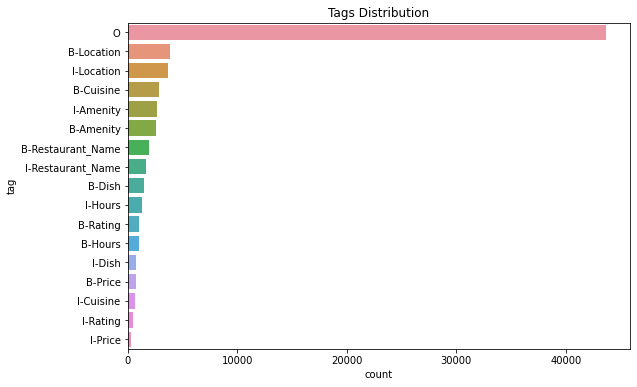

In [10]:
plt.figure(figsize=(9,6))
sns.countplot(y = train.tag, order=train.tag.value_counts().index)
plt.title('Tags Distribution')
plt.show()

In [11]:
train.tag.value_counts()

O                    43669
B-Location            3817
I-Location            3658
B-Cuisine             2839
I-Amenity             2676
B-Amenity             2541
B-Restaurant_Name     1901
I-Restaurant_Name     1668
B-Dish                1475
I-Hours               1283
B-Rating              1070
B-Hours                990
I-Dish                 767
B-Price                730
I-Cuisine              630
I-Rating               527
I-Price                283
Name: tag, dtype: int64

In [12]:
test.tag.value_counts()

O                    8659
B-Location            812
I-Location            788
B-Amenity             533
B-Cuisine             532
I-Amenity             524
B-Restaurant_Name     402
I-Restaurant_Name     392
I-Hours               295
B-Dish                288
B-Hours               212
B-Rating              201
B-Price               171
I-Cuisine             135
I-Rating              125
I-Dish                121
I-Price                66
Name: tag, dtype: int64

## Lemmatization

In [13]:
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ntyukaev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
train['text'] = train['text'].apply(lambda x: wordnet_lemmatizer.lemmatize(x))

In [15]:
test['text'] = test['text'].apply(lambda x: wordnet_lemmatizer.lemmatize(x))

In [16]:
train.head()

,sentence,tag,text
0,sentence_0,B-Rating,2
1,sentence_0,I-Rating,start
2,sentence_0,O,restaurant
3,sentence_0,O,with
4,sentence_0,B-Amenity,inside


## WordCloud

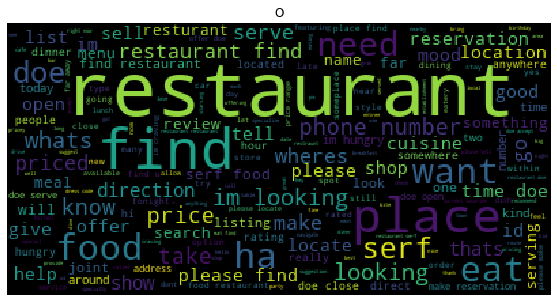

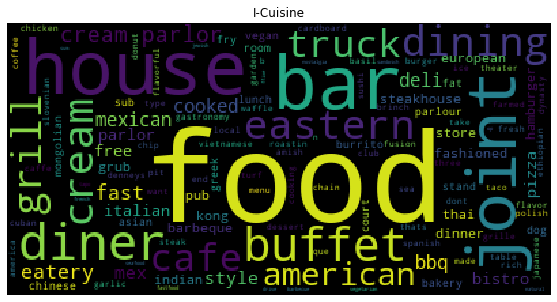

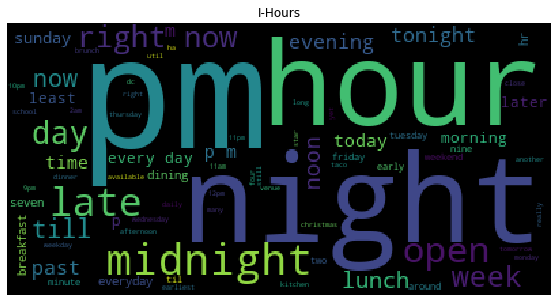

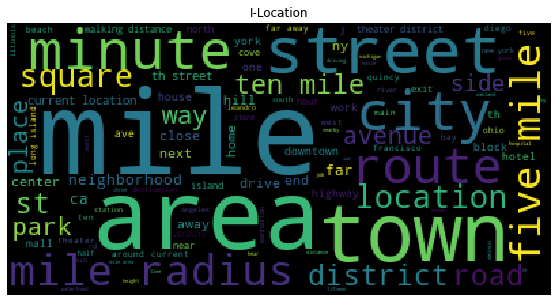

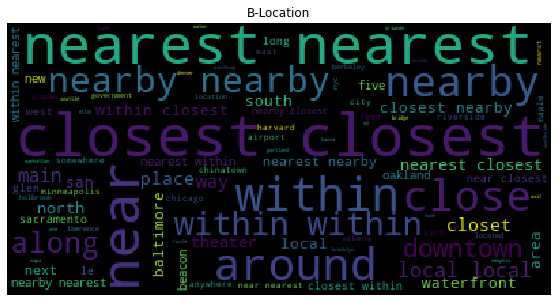

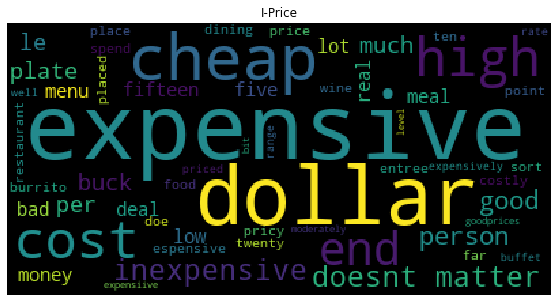

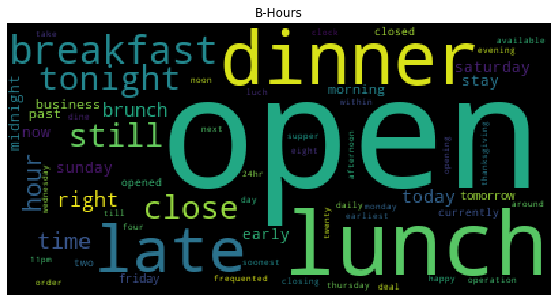

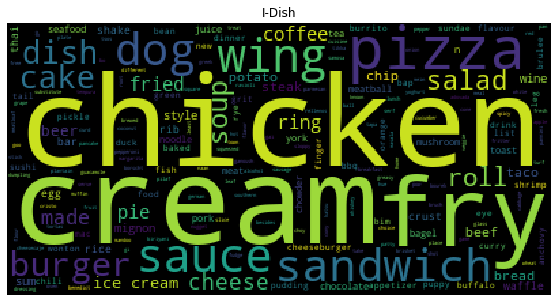

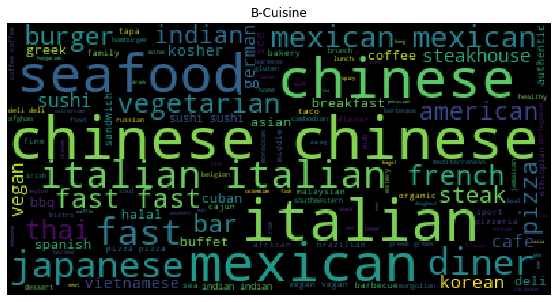

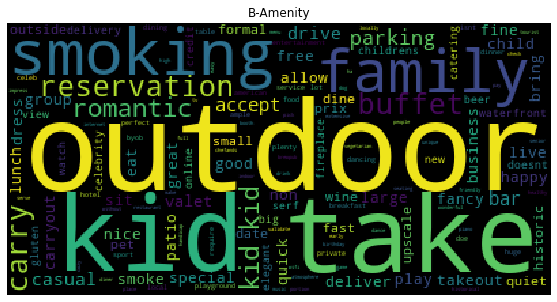

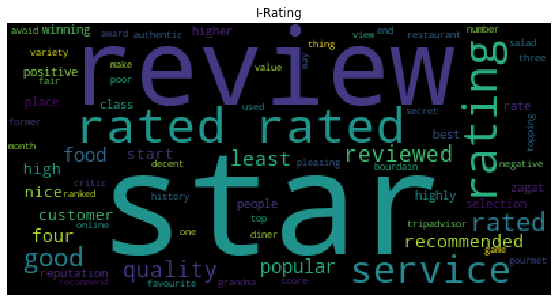

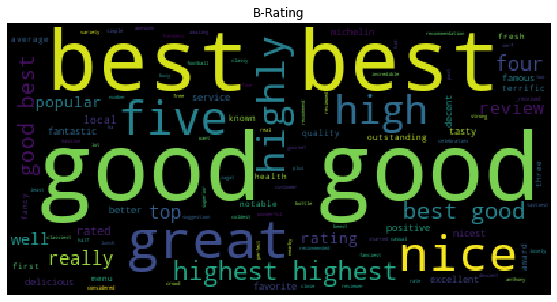

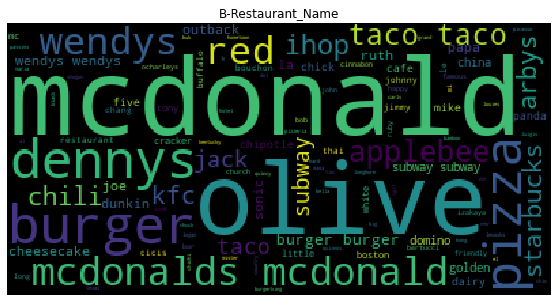

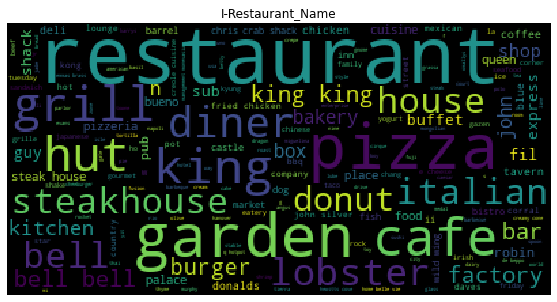

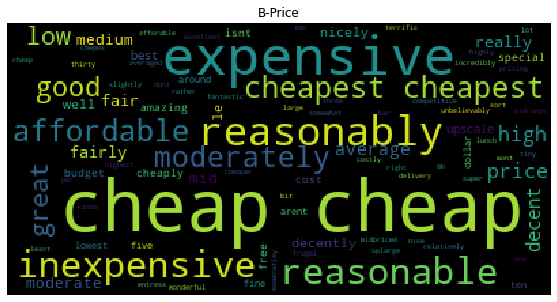

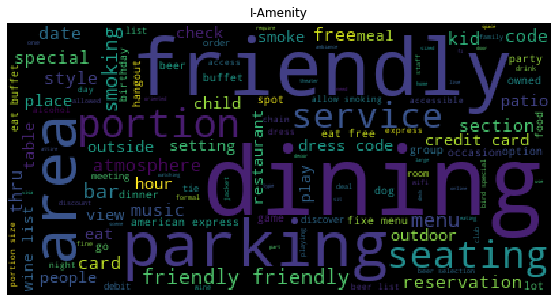

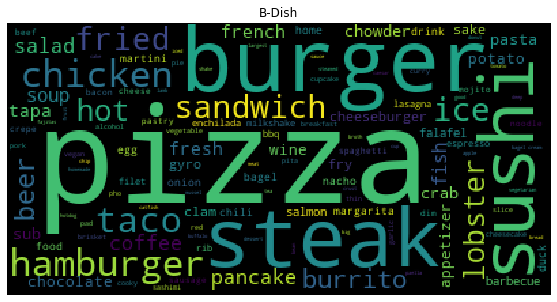

In [17]:
for tag in set(train.tag.values):
    vals = train[train['tag'] == tag]['text']
    wc = WordCloud().generate(' '.join(vals))
    plt.figure(figsize = (20,5))
    plt.title(tag)
    plt.axis('off')
    plt.imshow(wc, interpolation='nearest')
    plt.show()

### Sentence Distribution

In [18]:
sent_train = train.groupby('sentence').agg({'text': ' '.join})
sent_train['len'] = sent_train['text'].apply(lambda x: len(x))

In [19]:
sent_test = test.groupby('sentence').agg({'text': ' '.join})
sent_test['len'] = sent_test['text'].apply(lambda x: len(x))

In [20]:
sent_train['len'].describe()

count    7659.000000
mean       47.269617
std        18.459297
min         3.000000
25%        34.000000
50%        45.000000
75%        57.000000
max       169.000000
Name: len, dtype: float64

In [21]:
sent_test['len'].describe()

count    1521.000000
mean       48.199869
std        17.926004
min         3.000000
25%        35.000000
50%        46.000000
75%        58.000000
max       137.000000
Name: len, dtype: float64

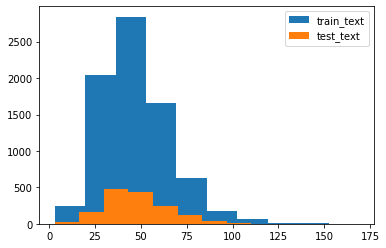

In [22]:
plt.hist(sent_train['len'], label='train_text')
plt.hist(sent_test['len'], label='test_text')
plt.legend()
plt.show()

The longest sentence has 170 words in it and we can see that almost all of the sentences have less than 60 words in them. For the ELMo embedding I'm setting the length of sentences to 60.

In [23]:
tag_to_idx = dict([(j, i)for i,j in enumerate(set(train['tag'].values))])
idx_to_tag = dict([(i, j)for i, j in enumerate(set(train['tag'].values))])

In [24]:
train['tag_idx'] = train['tag'].apply(lambda x: tag_to_idx[x])
test['tag_idx'] = test['tag'].apply(lambda x: tag_to_idx[x])

In [25]:

words = set(train['text'].values)
words.update(set(test['text'].values))
token_to_idx = dict([(j, i)for i,j in enumerate(words)])
idx_to_token = dict([(i, j)for i, j in enumerate(words)])

In [26]:
train['token_idx'] = train['text'].apply(lambda x: token_to_idx[x])
test['token_idx'] = test['text'].apply(lambda x: token_to_idx[x])

In [27]:
train.head()

,sentence,tag,text,tag_idx,token_idx
0,sentence_0,B-Rating,2,11,135
1,sentence_0,I-Rating,start,10,2022
2,sentence_0,O,restaurant,0,260
3,sentence_0,O,with,0,2040
4,sentence_0,B-Amenity,inside,9,811


In [28]:
test.head()

,sentence,tag,text,tag_idx,token_idx
0,sentence_0,O,a,0,155
1,sentence_0,B-Rating,four,11,3299
2,sentence_0,I-Rating,star,10,1965
3,sentence_0,O,restaurant,0,260
4,sentence_0,B-Location,with,4,2040


## Sentence Distribution

In [29]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [30]:
sent_train = train.groupby('sentence').agg(list)
sent_test = test.groupby('sentence').agg(list)

In [31]:
sent_train

,tag,text,tag_idx,token_idx
sentence,,,,
sentence_0,"[B-Rating, I-Rating, O, O, B-Amenity, I-Amenity]","[2, start, restaurant, with, inside, dining]","[11, 10, 0, 0, 9, 15]","[135, 2022, 260, 2040, 811, 2753]"
sentence_1,"[B-Rating, I-Rating, O, B-Location, I-Location...","[5, star, resturants, in, my, town]","[11, 10, 0, 4, 3, 3]","[1210, 1965, 659, 778, 10, 332]"
sentence_10,"[O, O, O, O, O, B-Price, B-Rating, O, B-Rating...","[about, how, much, is, a, midpriced, bottle, o...","[0, 0, 0, 0, 0, 14, 11, 0, 11, 8, 0, 12, 13, 13]","[432, 1559, 187, 422, 155, 1676, 1313, 2083, 3..."
sentence_100,"[O, O, O, B-Hours, I-Hours, B-Cuisine, B-Locat...","[are, there, any, 24, hour, diner, near, by]","[0, 0, 0, 6, 2, 8, 4, 3]","[2812, 2380, 3118, 586, 2007, 2985, 441, 961]"
sentence_1000,"[O, O, O, O, O, O, O, O, O, B-Amenity, I-Ameni...","[coul, you, please, locate, a, restaurant, tha...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 15, 0, 14, 5, 5]","[950, 3685, 3103, 1217, 155, 260, 747, 2745, 1..."
...,...,...,...,...
sentence_995,"[B-Location, B-Restaurant_Name]","[closest, mcdonalds]","[4, 12]","[2859, 3702]"
sentence_996,"[B-Location, O, O, O, B-Amenity, I-Amenity]","[closest, restaurant, with, a, play, place]","[4, 0, 0, 0, 9, 15]","[2859, 260, 2040, 155, 1096, 3151]"
sentence_997,"[B-Location, B-Restaurant_Name, O, O]","[closest, romanos, macaroni, grill]","[4, 12, 0, 0]","[2859, 2787, 3050, 15]"


In [32]:
train_tokens = sent_train['token_idx'].to_list()
test_tokens = sent_test['token_idx'].to_list()
train_tags = sent_train['tag_idx'].to_list()
test_tags = sent_test['tag_idx'].to_list()

max_len = max([len(s) for s in sent_train['token_idx'].to_list()])

train_tokens = pad_sequences(train_tokens, maxlen=max_len, dtype='int32', padding='post', value=len(token_to_idx))
test_tokens = pad_sequences(test_tokens, maxlen=max_len, dtype='int32', padding='post', value=len(token_to_idx))

train_tags = pad_sequences(train_tags, maxlen=max_len, dtype='int32', padding='post', value=tag_to_idx['O'])
train_tags = np.array([to_categorical(i, num_classes=len(tag_to_idx)) for i in train_tags])

test_tags = pad_sequences(test_tags, maxlen=max_len, dtype='int32', padding='post', value=tag_to_idx['O'])
test_tags = np.array([to_categorical(i, num_classes=len(tag_to_idx)) for i in test_tags])

In [33]:
for token, tag in zip(train_tokens[0], train_tags[0]):
    print('%s\t%s' % (token, tag))

135	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
2022	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
260	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2040	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
811	[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
2753	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
3805	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3805	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3805	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3805	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3805	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3805	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3805	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3805	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3805	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3805	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3805	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3805	[1. 0. 0. 0.

## Model

In [79]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from keras import backend as K

In [80]:
def get_model():
    input_dim = set(train['text'].to_list())
    input_dim.update(set(test['text'].to_list()))
    input_dim = len(input_dim) + 1
    output_dim = 32

    tok_idx = sent_train['token_idx'].tolist()
    tok_idx.extend(sent_test['token_idx'].to_list())
    input_length = max([len(s) for s in tok_idx])
    n_tags = len(tag_to_idx)
    model = Sequential()

    # Add Embedding layer 3806
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser 
    adam = tf.keras.optimizers.Adam(learning_rate=0.01, decay=1e-6)

    # Compile model
    # model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.compile(loss=[tfa.losses.SigmoidFocalCrossEntropy()], optimizer=adam, metrics=['accuracy'])
    model.summary()
    
    return model

In [81]:
lstm_model = get_model()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 35, 32)            121792    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 35, 64)            16640     
_________________________________________________________________
lstm_9 (LSTM)                (None, 35, 32)            12416     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 35, 17)            561       
Total params: 151,409
Trainable params: 151,409
Non-trainable params: 0
_________________________________________________________________


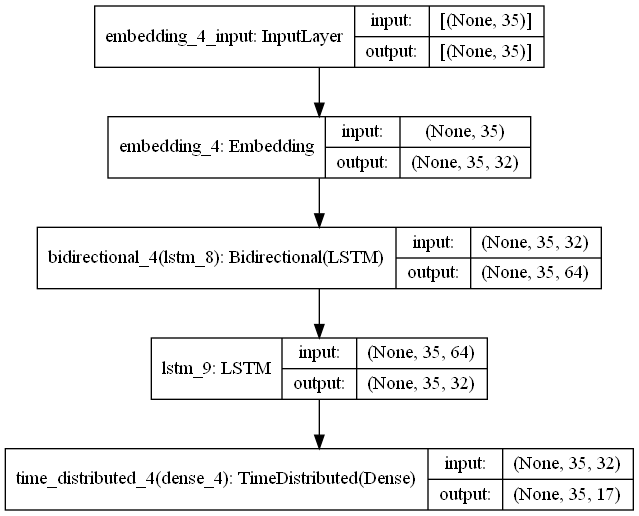

In [82]:
plot_model(lstm_model, show_shapes=True)

### Train Model

In [90]:
epochs = 25
loss = []
for i in range(epochs):
    history = lstm_model.fit(train_tokens, np.array(train_tags), batch_size=20, verbose=1, epochs=1, validation_split=0.2)
    loss.append(history.history['loss'][0])

287/307 [===========================>..] - ETA: 0s - loss: 0.0186 - accuracy: 0.9735

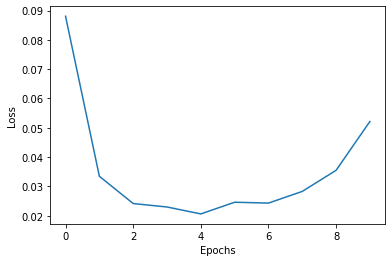

In [84]:
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [85]:
test_pred = lstm_model.predict(test_tokens)

In [86]:
import copy
def pred_to_label(pred):
    out = []
    for sent in pred:
        s = []
        for t in sent:
            idx = np.argmax(t)
            tag = idx_to_tag[idx]
            s.append(tag)
        out.append(s)
    return np.array(out).flatten()

In [87]:
from sklearn.metrics import classification_report

In [88]:
y_true = pred_to_label(test_tags)
y_pred = pred_to_label(test_pred)

In [89]:
print(classification_report(y_true, y_pred))

c:\users\ntyukaev\.conda\envs\bot\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

        B-Amenity       0.12      0.22      0.16       533
        B-Cuisine       0.88      0.54      0.67       532
           B-Dish       0.63      0.37      0.47       288
          B-Hours       0.60      0.57      0.58       212
       B-Location       0.79      0.77      0.78       812
          B-Price       0.85      0.64      0.73       171
         B-Rating       0.85      0.53      0.65       201
B-Restaurant_Name       0.00      0.00      0.00       402
        I-Amenity       0.82      0.23      0.36       524
        I-Cuisine       0.00      0.00      0.00       135
           I-Dish       1.00      0.05      0.09       121
          I-Hours       0.75      0.90      0.82       295
       I-Location       0.73      0.83      0.78       788
          I-Price       0.86      0.36      0.51        66
         I-Rating       0.82      0.67      0.74       125
I-Restaurant_Name       0.64      0.50      0.56       

c:\users\ntyukaev\.conda\envs\bot\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\ntyukaev\.conda\envs\bot\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
